In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
%matplotlib inline

In [30]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'
electron_input = '../../cta_rta_analysis/build/electrons_test.hdf5'
t_obs = 1 * u.s
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins)

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy']

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)


electrons = fact.io.read_data(electron_input, key='array_events', columns=columns)
electrons = electrons.dropna()
electrons['type'] = 2
electron_runs = fact.io.read_data(electron_input, key='runs')
mc_production_electron = MCSpectrum.from_cta_runs(electron_runs)


cosmic_proton = CosmicRaySpectrum()
cosmic_electron = CTAElectronSpectrum()

protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
electrons['weight'] = mc_production_electron.reweigh_to_other_spectrum(cosmic_electron, electrons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

In [31]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

protons['theta'] = calculate_theta(protons)
electrons['theta'] = calculate_theta(electrons)

background = protons.append(electrons)
background['energy_bin'] = pd.cut(background.gamma_energy_prediction_mean, bins=bin_edges)


/usr/local/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


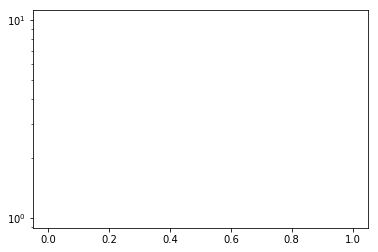

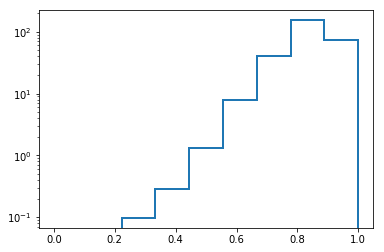

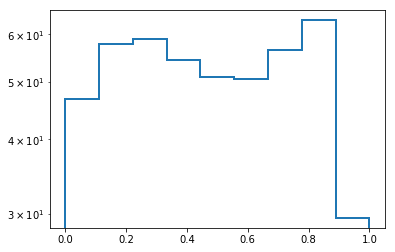

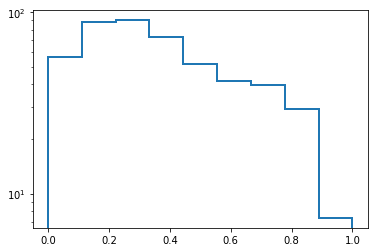

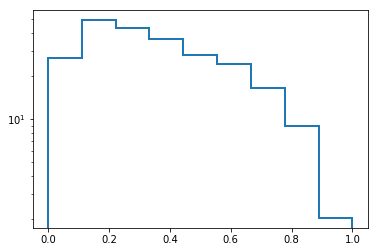

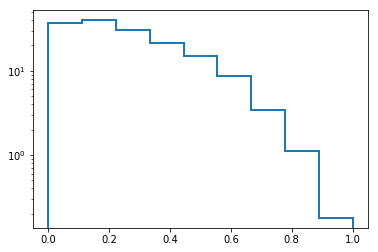

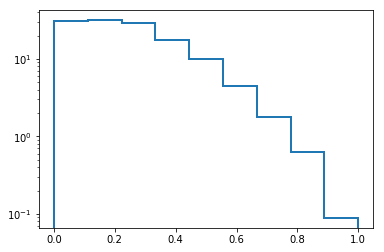

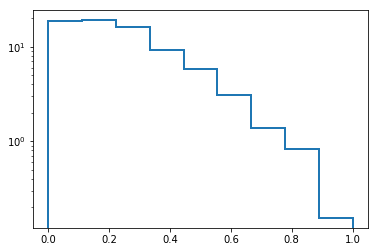

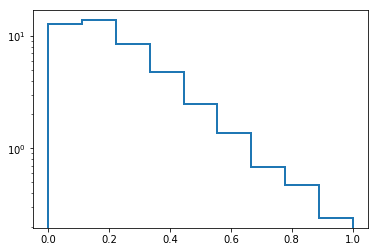

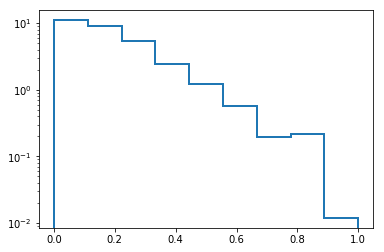

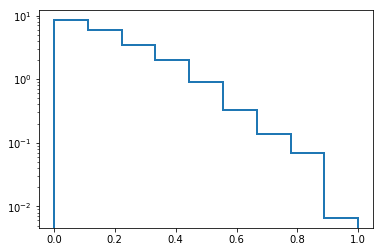

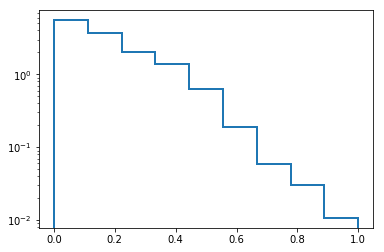

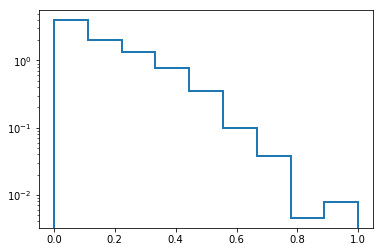

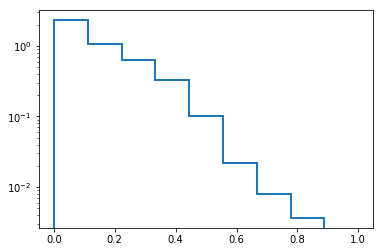

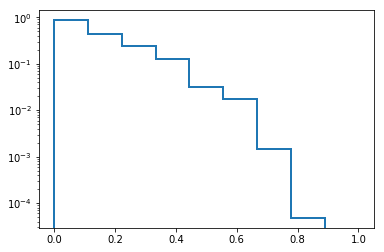

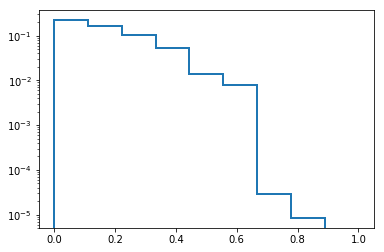

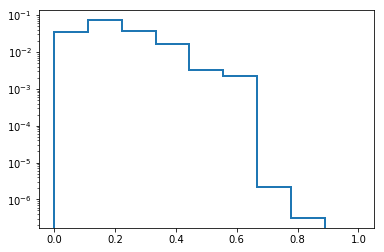

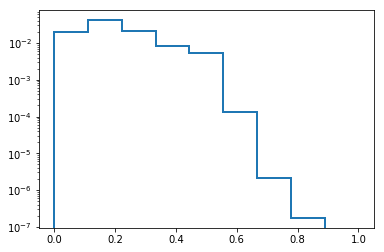

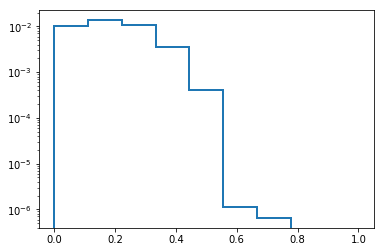

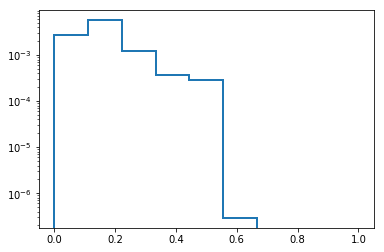

<Figure size 432x288 with 0 Axes>

In [32]:

for n, group in background.groupby('energy_bin'):
    
    b = group.query('theta <= 1')
    plt.hist(b.gamma_prediction_mean, bins=np.linspace(0, 1, 10), histtype='step', lw=2, weights=b.weight)
    plt.yscale('log')
    plt.figure()
None

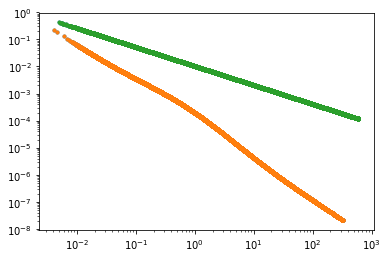

In [33]:
plt.plot(background.mc_energy, background.weight, '.')
plt.plot(electrons.mc_energy, electrons.weight, '.')
plt.plot(protons.mc_energy, protons.weight, '.')
plt.yscale('log')
plt.xscale('log')

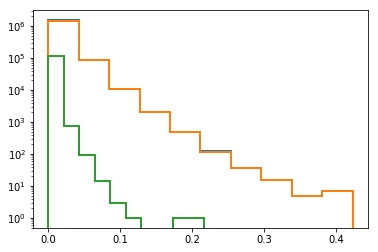

In [34]:
plt.hist(background.weight, lw='2', histtype='step')
plt.hist(protons.weight, lw='2', histtype='step')
plt.hist(electrons
         .weight, lw='2', histtype='step')
plt.yscale('log')
None